In [1]:
# importing the libraries
from IPython.display import display
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec, KeyedVectors
from datasets import load_dataset
import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, kneighbors_graph
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import warnings
from pandas.core.common import SettingWithCopyWarning

In [2]:
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
# downloading nltk.punkt
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

### Defining relevant functions

In [4]:
def word_cloud_plot (data):
    """
    function that creates a word cloud from a specified column of a dataframe 
    """
    # create set of stopwords
    stopwords = set(STOPWORDS)

    # Instantiate the word cloud object
    word_cloud = WordCloud(background_color='white',max_words=200,stopwords=stopwords, width=800, height=400)
    
    # generate the word cloud
    word_cloud.generate(' '.join(data))
    
    # To display the word cloud
    plt.figure( figsize=(20,10) )
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [5]:
def regex_filter(sentence):
    """
    funtion that formats string to remove special characters
    """
    import re
    return re.sub('[^a-zA-Z]', ' ', sentence)

In [6]:
def filter_stop_words(token):
    """
    function that removes stopwords from a word-tokenized sentence
    """
    stop_words = set(stopwords.words('english'))
    filtered_token = [word.lower() for word in token if word.lower() not in stop_words]
    return filtered_token

In [7]:
def stem_words(token):
    """
    function that stems word-tokenized sentences
    """
    ps = PorterStemmer()
    stemmed_token = [ps.stem(word) for word in token]
    return stemmed_token

In [8]:
def lemmatize_words(token):
    """
    function that lemmatizes word-tokenized sentences
    """
    lem = WordNetLemmatizer()
    lemmatized_token = [lem.lemmatize(word, 'v') for word in token]
    return lemmatized_token

In [9]:
def join_token(token):
    """
    function that joins word-tokenized sentences back to single string
    """
    return ' '.join(token)

In [10]:
def get_embeddings(group, model):
    """
    Function for getting embeddings of words from a word2vec model 
    """
    group_embedding = []
    group_labels = []
    
    unique_words = [word for sentence in group for word in sentence]
    unique_words = list(dict.fromkeys(unique_words))
    
    for word in unique_words:
        if model.wv.__contains__(word):
            group_embedding.append(list(model.wv.__getitem__(word)))
            group_labels.append(word)
            
    df_embedding = pd.DataFrame(group_embedding)
    df_word = pd.DataFrame(group_labels, columns = ["Word"])
    df = pd.concat([df_word, df_embedding], axis=1)
    return df

In [11]:
def similarity(words, stem_model=None, lem_model=None, W2V_pretrained=None, GloVe_pretrained=None):
    """
    function that computes similarity between words for up to four models passed 
    """
    if stem_model:
        ps = PorterStemmer()
        stemmed = [ps.stem(word) for word in words]
        try:
            print("Stemmed W2V model similarity between", words[0], "and", words[1], "=", round(stem_model.wv.similarity(stemmed[0], stemmed[1]), 2))
        except:
            print("Error: Word not in stem model vocabulary")
    
    if lem_model:
        lem = WordNetLemmatizer()
        lemma = [lem.lemmatize(word, 'v') for word in words]
        try:
            print("Lemmatized W2V model similarity between", words[0], "and", words[1], "=", round(lem_model.wv.similarity(lemma[0], lemma[1]), 2))
        except:
            print("Error: Word not in lemmatized model vocabulary")        
    
    if W2V_pretrained:
        try:
            print("Word2vec pretrained model similarity between", words[0], "and", words[1], "=", round(W2V_pretrained.wv.similarity(words[0], words[1]), 2))
        except:
            print("Error: Word not in Word2vec pretrained model vocabulary")
    
    if GloVe_pretrained:
        try:
            print("GloVe pretrained model similarity between", words[0], "and", words[1], "=", round(GloVe_pretrained.similarity(words[0], words[1]), 2))
        except:
            print("Error: Word not in GloVe pretrained model vocabulary")    

In [12]:
def tsne_plot(df):
    """
    function that plots annotated scatter plot from a dataframe
    """
    plt.figure(figsize=(18, 18)) 
    for i in range(len(df)):
        plt.scatter(df.iloc[i,1],df.iloc[i,2])
        plt.annotate(df.iloc[i,0],
                     xy=(df.iloc[i,1], df.iloc[i,2]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [13]:
def get_sentence_embedding(data, column, train_word_embedding, test_word_embedding):
    """
    function that creates a sentence embedding from the embeddings of the individual words
    sentence_embedding = average of word embeddings for all words in the sentence
    """
    data.reset_index(inplace=True, drop = True)
    sentence_embeddings = []
    for token in data[column]:
        embeddings = []
        for word in token:
            if word in train_word_embedding.index:
                embeddings.append(train_word_embedding.loc[word])
            else:
                embeddings.append(test_word_embedding.loc[word])
        
        embedding_array = np.array(embeddings)
        sentence_embedding = np.mean(embedding_array, axis=0)
        sentence_embeddings.append(list(sentence_embedding))
        
    features = len(sentence_embeddings[0])
    df = pd.DataFrame(sentence_embeddings, columns = ["feature_"+ str(i+1) for i in range(features)])
    df = pd.concat([data["claim"], df, data["claim_label"]], axis=1)
    return df   

In [14]:
def get_most_similar_words(embedding, n_similar = 1):
    """
    function that returns n_similar most similar words to a particular word in an embedding. 
    embedding is n x n square matrix of relationship (similarity) between words
    """
    n_similar += 1
    similar = pd.DataFrame(columns = ['most_similar_'+ str(i) for i in range(1, n_similar)])
    
    embedding_T = embedding.T
    for word in embedding.index:
        most_similar = list(embedding_T.nlargest(n = n_similar, columns = word).index)
        if word in most_similar:
            most_similar.remove(word)
        else:
            most_similar = most_similar[:-1]
            
        similar.loc[word] = most_similar
    
    return similar

In [15]:
def precision_recall_fscore(y_true, y_pred):
    """
    function that computes the precision, recall and fscore between 2 dataframes across n_columns columns
    returns the average precision, recall and fscore across the n_columns
    """
    if len(y_true) != len(y_pred):
        print("Error in dimensions of inputs")
        return
    
    n_columns = len(y_true)
    metrics = []
    
    for i in range(n_columns):
        metric = list(precision_recall_fscore_support(y_true.iloc[:,i], y_pred.iloc[:,i], average='macro'))
        metrics.append(metric[:-1])
       
    metrics = np.mean(np.array(metrics), axis=0)
        
    print("Precision: ", round(metrics[0], 2))
    print("Recall: ", round(metrics[1], 2))
    print("F1_score: ", round(metrics[2], 2))
    

In [16]:
def run_knn_opt(X_train, X_val, X_test, y_train, y_val, y_test, k_values):
    """
    function that performs tunning of k_parameter in KNN classifier
    produces confusion matrix, accuracy, fscore and screeplots
    """
    # Developing the Classification Model
    classifier = KNeighborsClassifier()
    classifier.fit(X_train,y_train)

    # Predicting the test set result
    y_pred = classifier.predict(X_test)

    # Evaluating the Model
    cm = confusion_matrix(y_test,y_pred)

    accuracy_1 = round(100 * accuracy_score(y_test,y_pred), 2)
    f1_score_1 = round(f1_score(y_test, y_pred, average = "weighted"), 2)

    y_pred_train  = classifier.predict(X_train)
    
    # Making the Confusion Matrix
    cm_train = pd.DataFrame(confusion_matrix(y_train,y_pred_train))
    cm_test = pd.DataFrame(confusion_matrix(y_test,y_pred))

    print("***** Training Set Evaluation *****\n")
    print("confusion Matrix")
    display(cm_train)
    print("Accuracy: ", round(100 * accuracy_score(y_train, y_pred_train), 2))
    print("F1_score: ", round(f1_score(y_train, y_pred_train, average = 'weighted'), 2))
    
    print("\n\n***** Test Set Evaluation *****\n")
    print("confusion Matrix")
    display(cm_test)
    print("Accuracy: ", accuracy_1)
    print("F1_score: ", f1_score_1)
    
    accuracy = {}
    for k in k_values:
        classifier = KNeighborsClassifier(n_neighbors=k)
        classifier.fit(X_train,y_train)

        # Predicting the test set result
        y_pred = classifier.predict(X_val)

        model_accuracy = accuracy_score(y_val, y_pred)

        accuracy[k] = round(model_accuracy * 100, 2)
        
    # plotting the parameter vs accuracy graph
    sns.lineplot(x = k_values, y = accuracy.values())

### Downloading the dataset

In [17]:
dataset = load_dataset('climate_fever')

df = dataset['test'].to_pandas()
df2 = pd.json_normalize(dataset['test'], 'evidences', ['claim', 'claim_id','claim_label'], errors='ignore',record_prefix='')

data1 = df[['claim', 'claim_label']]
data2 = df2[['evidence','evidence_label']]

Using custom data configuration default
Reusing dataset climate_fever (C:\Users\jubil\.cache\huggingface\datasets\climate_fever\default\1.0.1\3b846b20d7a37bc0019b0f0dcbde5bf2d0f94f6874f7e4c398c579f332c4262c)


# Data preparation

### Claim Data

In [18]:
# filter with regex
data1.loc[:, 'claim_token'] = data1.loc[:, 'claim'].apply(regex_filter)

# Tokenizing the claims
data1.loc[:, 'claim_token'] = data1.loc[:, 'claim_token'].apply(nltk.word_tokenize)

# Removing stop words from the claclaim_tokenim tokens
data1.loc[:,'claim_token'] = data1.loc[:,'claim_token'].apply(filter_stop_words)

# Stemming the words
data1.loc[:,'stemmed_words'] = data1.loc[:,'claim_token'].apply(stem_words)

# lemmatizing the words
data1.loc[:,'lemmatized_words'] = data1.loc[:,'claim_token'].apply(lemmatize_words)

### Evidence Data

In [19]:
# Adding the evidences to increase corpus size

# filer with regex
data2.loc[:, ('evidence_token')] = data2.loc[:, ('evidence')].apply(regex_filter)

# Tokenizing the claims
data2.loc[:, ('evidence_token')] = data2.loc[:, ('evidence_token')].apply(nltk.word_tokenize)

# Removing stop words from the evidence_token tokens
data2.loc[:,('evidence_token')] = data2.loc[:,('evidence_token')].apply(filter_stop_words)

# Stemming the words
data2.loc[:,('stemmed_words')] = data2.loc[:,('evidence_token')].apply(stem_words)

# lemmatizing the words
data2.loc[:,('lemmatized_words')] = data2.loc[:,('evidence_token')].apply(lemmatize_words)

In [20]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data1[['claim', 'stemmed_words', 'lemmatized_words', 'claim_label']], test_size=0.2, random_state=0)

In [21]:
# creating the stemmed corpus and lemmatized corpus
corpus_stem = list(data1['stemmed_words']) + list(data2['stemmed_words'])
corpus_lem = list(data1['lemmatized_words']) + list(data2['stemmed_words'])

In [22]:
# Embeding with Word2Vec
model_stem = Word2Vec(corpus_stem, min_count=1)
model_lem = Word2Vec(corpus_lem, min_count=1)
print(model_stem)
print(model_lem)

Word2Vec(vocab=7433, size=100, alpha=0.025)
Word2Vec(vocab=8894, size=100, alpha=0.025)


In [23]:
# Training set embedings [STEMMING]
train_embedding_stem = get_embeddings(list(train_data['stemmed_words']), model_stem)
train_embedding_stem.set_index("Word", inplace=True)
train_embedding_stem.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Word,,,,,,,,,,,,,,,,,,,,,
pdo,-0.007563,0.044511,0.025590,-0.035496,-0.064830,-0.239282,-0.128552,-0.027723,0.190765,-0.015688,...,0.050520,0.029647,0.034425,0.062681,-0.070394,0.140967,-0.133364,0.204884,-0.007596,0.037768
last,-0.130583,0.167503,0.617398,-0.159868,-0.395399,-1.272915,-0.145560,0.325738,0.822741,0.268655,...,0.307845,0.512742,-0.005760,0.531633,0.249027,0.766805,-0.681059,1.256987,-0.018639,0.262311
switch,-0.031355,0.004839,0.028413,-0.048590,-0.052671,-0.080059,-0.106902,-0.054508,0.083893,-0.007816,...,-0.030654,-0.033957,0.003122,0.003249,-0.086289,0.059817,-0.070656,0.077227,-0.006081,0.002155
cool,-0.021669,0.253109,0.278511,0.182573,-0.496178,-0.906144,0.052943,0.026868,0.667943,-0.007229,...,0.300090,0.196583,0.257938,0.198781,-0.140453,0.634068,-0.518127,0.844347,0.023503,0.254012
phase,-0.086800,0.123085,0.126501,-0.072909,-0.184174,-0.569626,-0.351786,-0.063643,0.465036,-0.067906,...,0.099032,0.021727,0.040485,0.129960,-0.179157,0.282377,-0.295625,0.500384,-0.043117,0.074288


In [24]:
# Training set embedings [LEMMATIZING]
train_embedding_lem = get_embeddings(list(train_data['lemmatized_words']), model_lem)
train_embedding_lem.set_index("Word", inplace=True)
train_embedding_lem.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Word,,,,,,,,,,,,,,,,,,,,,
pdo,-0.074875,0.252571,-0.103052,0.053736,0.039467,-0.101775,0.024312,-0.153328,0.196491,-0.070434,...,0.135452,-0.144188,0.020973,0.148089,-0.182725,0.215478,-0.103646,0.009041,-0.037936,-0.007843
last,-0.307621,0.735764,0.276465,0.119051,-0.227690,-0.712704,0.301766,-0.359552,0.787539,0.080348,...,0.934104,-0.470115,0.287291,0.863993,-0.548263,1.154273,-0.657285,0.659612,0.257063,0.113611
switch,-0.051504,0.115070,-0.033129,0.015233,0.010408,-0.019066,0.002020,-0.105870,0.094986,-0.030600,...,0.014627,-0.095206,-0.005678,0.038206,-0.107577,0.101354,-0.058799,-0.014360,-0.030403,-0.015044
cool,-0.285945,0.853142,-0.080562,0.459503,-0.192052,-0.517079,0.485993,-0.526372,0.745424,-0.200618,...,0.767316,-0.659193,0.388635,0.525588,-0.664032,0.909027,-0.509181,0.258207,0.058263,0.183029
phase,-0.267871,0.633408,-0.186877,0.156740,0.063929,-0.223141,0.027060,-0.373447,0.482683,-0.193931,...,0.312610,-0.416590,0.004674,0.327273,-0.452579,0.468214,-0.231901,0.021655,-0.107761,-0.034945


### <span style="color:blue">Getting the test set embeddings</span>

In [25]:
# Test set embedings [STEMMING]
test_embedding_stem = get_embeddings(list(test_data['stemmed_words']), model_stem)
test_embedding_stem.set_index("Word", inplace=True)
test_embedding_stem.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Word,,,,,,,,,,,,,,,,,,,,,
trenberth,-0.017038,0.013299,0.002177,-0.029537,-0.021646,-0.067447,-0.067976,-0.020581,0.063339,-0.014457,...,-0.003351,-0.009252,0.002696,0.014170,-0.042781,0.037007,-0.044133,0.067621,-0.009451,0.005136
view,-0.018748,0.064682,0.002448,-0.129314,-0.023861,-0.462953,-0.367762,-0.032959,0.340256,-0.070246,...,0.089662,0.111815,0.033272,0.124180,-0.146366,0.221877,-0.255811,0.408047,-0.014512,0.056236
clarifi,-0.001354,0.006540,0.003853,-0.003351,-0.002437,-0.017939,-0.014778,-0.002117,0.013376,-0.003929,...,0.001620,-0.003386,0.002880,0.005302,-0.010811,0.004044,-0.010859,0.006654,-0.000468,0.005740
paper,-0.028626,0.070783,-0.072200,-0.289876,0.059990,-0.616429,-0.761886,-0.152431,0.531911,-0.171467,...,0.110546,0.056905,0.025860,0.177836,-0.277338,0.215289,-0.330457,0.543636,-0.043234,0.062558
imper,-0.012223,0.007623,-0.007936,-0.020599,-0.005858,-0.064724,-0.064233,-0.013333,0.051719,-0.014259,...,0.003453,0.007280,-0.000593,0.010461,-0.036715,0.026428,-0.032237,0.055030,-0.005217,-0.000506


In [26]:
# Test set embedings [LEMMATIZING]
test_embedding_lem = get_embeddings(list(test_data['lemmatized_words']), model_lem)
test_embedding_lem.set_index("Word", inplace=True)
test_embedding_lem.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Word,,,,,,,,,,,,,,,,,,,,,
trenberth,-0.042692,0.106644,-0.039109,0.013503,0.017004,-0.025219,0.002146,-0.066980,0.079001,-0.033721,...,0.030847,-0.073518,-0.004599,0.046776,-0.076268,0.073033,-0.037316,0.000369,-0.027196,-0.008368
view,-0.124928,0.501030,-0.212534,0.048093,0.140766,-0.189625,-0.004337,-0.323847,0.382702,-0.157046,...,0.212705,-0.242181,0.006628,0.286252,-0.392296,0.445009,-0.221103,0.016011,-0.080514,-0.031985
clarify,0.001797,0.007571,-0.004464,-0.004013,0.001436,-0.003795,0.002320,-0.002964,0.004810,0.000449,...,0.004331,-0.006660,-0.005121,0.001221,-0.005890,0.010113,-0.003096,-0.003324,0.001403,0.001936
paper,-0.193147,0.830351,-0.447796,0.003107,0.331940,-0.203153,-0.192300,-0.552235,0.606344,-0.305153,...,0.262673,-0.387253,-0.096878,0.437857,-0.613819,0.552874,-0.258631,-0.064353,-0.178787,-0.108222
imperative,-0.002352,0.013623,-0.004010,0.004259,0.006063,-0.002932,0.000861,-0.010286,0.008455,-0.001230,...,0.003034,-0.008911,-0.000950,0.007447,-0.012040,0.012527,-0.006425,-0.006856,-0.005544,-0.001544


## LLE

Locally linear embedding (LLE) seeks a lower-dimensional projection of the data which preserves distances within local neighborhoods. LLE unfolds the non-linear manifold in a piecewise manner. The standard LLE algorithm comprises of 3 steps
1. Construct the KNN graph.
2. Calculate the reconstruction weights for reconstructing every point by its neighbours.
3. Use the obtained weights to embed the points in a low dimensional space.

## <span style="color:blue">Q.1 </span>

### Using Stemming

In [27]:
from sklearn.manifold import LocallyLinearEmbedding

In [28]:
n_components = [1, 2, 3, 5, 7, 10, 20, 30]
reconstruction_error = []
for n in n_components:
    lle_model = LocallyLinearEmbedding(n_components=n, random_state=0)
    lle_test = lle_model.fit_transform(test_embedding_stem.iloc[:,:].values)
    reconstruction_error.append(lle_model.reconstruction_error_)

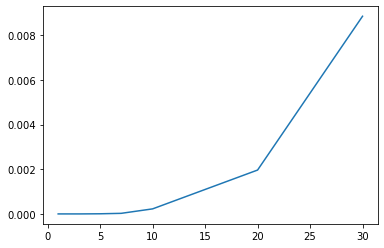

In [29]:
plt.plot(n_components, reconstruction_error)

In [30]:
%%time
lle_model = LocallyLinearEmbedding(n_components=4, random_state=0)
lle_test = lle_model.fit_transform(test_embedding_stem.iloc[:,:].values)

lle_test = pd.DataFrame(lle_test, columns = ["feature1", "feature2", "feature3", "feature4"])
lle_test.index = test_embedding_stem.index

Wall time: 338 ms


In [31]:
lle_test.head()

,feature1,feature2,feature3,feature4
Word,,,,
trenberth,-0.008398,-0.004796,0.005225,0.037093
view,-0.014039,0.016293,0.021334,-0.031066
clarifi,-0.011228,-0.066904,0.010288,-0.007664
paper,0.072247,-0.000074,0.001254,-0.011154
imper,-0.009847,-0.036586,-0.006689,0.015336


In [32]:
lle_model.reconstruction_error_

7.764554481358607e-07

## <span style="color:blue"> Q.2 </span>

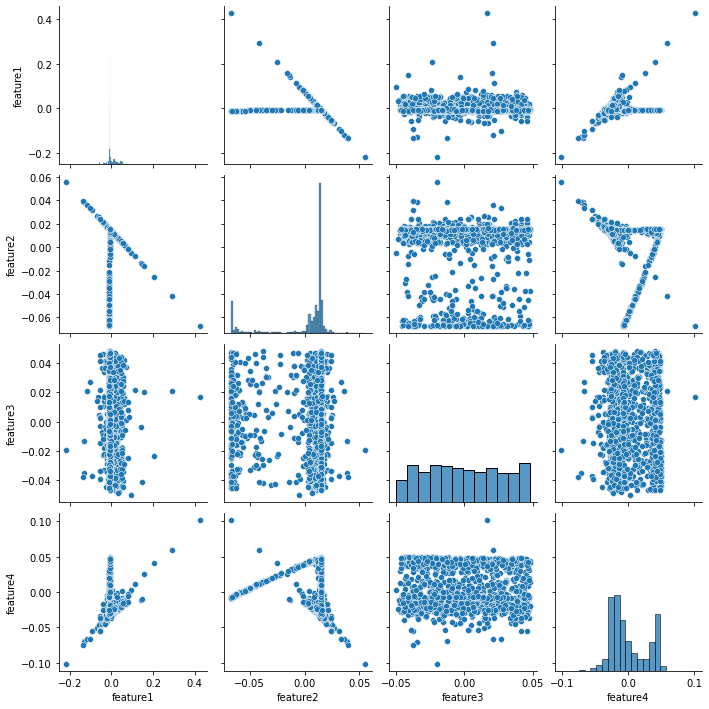

In [33]:
sns.pairplot(lle_test)

###  <span style="color:blue">Discussions on the LLE Embeddings [STEMMING]</span>

- The largest range of embeddings is 0.1
- The plots of all the features are arbitrary shapes.
- The distribution of the feature 2 is skewed to the right
- The training time for the LLE transformation was 338ms

### Using Lemmatization

In [34]:
n_components = [1, 2, 3, 5, 7, 10, 20, 30]
reconstruction_error = []
for n in n_components:
    lle_model = LocallyLinearEmbedding(n_components=n, random_state=0)
    lle_test_lem = lle_model.fit_transform(test_embedding_lem.iloc[:,:].values)
    reconstruction_error.append(lle_model.reconstruction_error_)

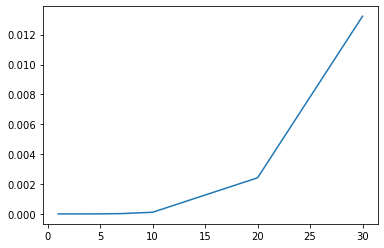

In [35]:
plt.plot(n_components, reconstruction_error)

In [36]:
%%time
lle_model = LocallyLinearEmbedding(n_components=4, random_state=0)
lle_test_lem = lle_model.fit_transform(test_embedding_lem.iloc[:,1:].values)

lle_test_lem = pd.DataFrame(lle_test_lem, columns = ["feature1", "feature2", "feature3", "feature4"])
lle_test_lem.index = test_embedding_lem.index

Wall time: 429 ms


In [37]:
lle_test_lem.head()

,feature1,feature2,feature3,feature4
Word,,,,
trenberth,0.002264,0.003789,0.016586,-0.043139
view,0.000715,0.002328,-0.031027,0.019274
clarify,0.002293,0.006537,0.035892,0.036470
paper,0.001516,-0.018307,-0.027152,0.019633
imperative,0.002293,0.006522,0.035780,0.035712


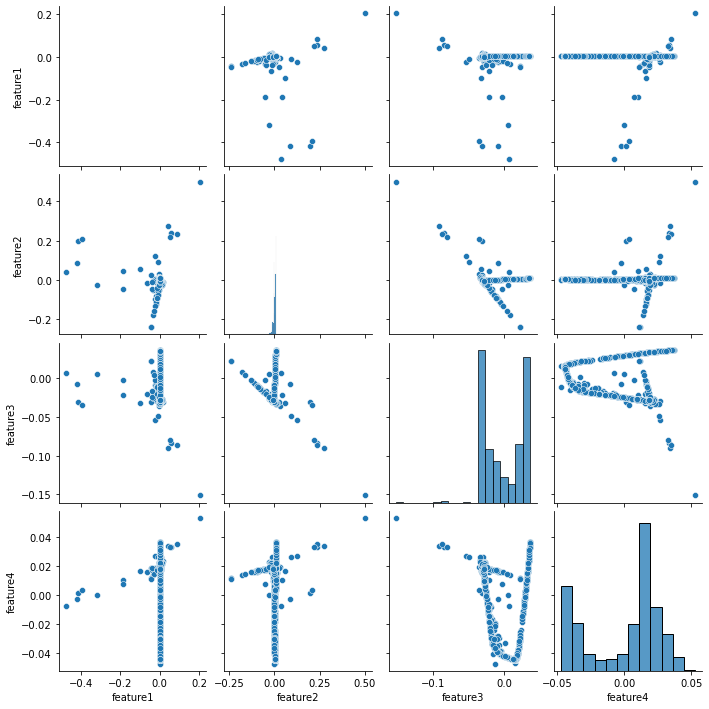

In [38]:
sns.pairplot(lle_test_lem)

In [39]:
lle_model.reconstruction_error_

1.3026465750707678e-06

###  <span style="color:blue">Discussions on the LLE Embeddings [LEMMATIZING]</span>

- The largest range of embeddings is 0.6
- The plots of all the features are arbitrary shapes.
- The distribution of the feature 3 and feature 2 are skewed to the right.
- The training time for the LLE transformation was 429ms

## <span style="color:blue">Q.3 Cosine Similarity LLE </span>

### Getting Cosine Similarity from word2vec Embeddings

#### Getting Cosine similarity between all  words in test set [STEMMING]

In [40]:
# set cosine similarity threshold for defining similar words for comparing the different embeddings
cos_threshold = 0.99 

In [41]:
cos_sim_w2v = cosine_similarity(test_embedding_stem.iloc[:,:].values, Y=None, dense_output=True)
cos_sim_w2v.shape

(1291, 1291)

In [42]:
cos_sim_w2v = pd.DataFrame(cos_sim_w2v, 
                           columns = list(test_embedding_stem.index), 
                           index = list(test_embedding_stem.index)
                          )
cos_sim_w2v.head()

,trenberth,view,clarifi,paper,imper,climat,chang,plan,track,earth,...,tropospher,moreov,coldest,donald,hoax,classic,feast,follow,coupl,recoveri
trenberth,1.000000,0.976370,0.936243,0.966142,0.989991,0.754860,0.754498,0.996683,0.920326,0.801413,...,0.903886,0.982326,0.859665,0.985882,0.992708,0.987686,0.967176,0.946169,0.973572,0.992722
view,0.976370,1.000000,0.932005,0.978668,0.983556,0.815498,0.808264,0.967623,0.950666,0.810010,...,0.852425,0.951244,0.899431,0.983297,0.990127,0.973945,0.946142,0.945017,0.988824,0.981173
clarifi,0.936243,0.932005,1.000000,0.927367,0.932369,0.665868,0.674442,0.935049,0.916528,0.744210,...,0.802922,0.932537,0.874348,0.947359,0.944036,0.947465,0.917450,0.923281,0.941393,0.948993
paper,0.966142,0.978668,0.927367,1.000000,0.983515,0.792883,0.760241,0.959463,0.920617,0.689803,...,0.782500,0.959741,0.854728,0.979366,0.984379,0.965105,0.952651,0.910338,0.985372,0.974046
imper,0.989991,0.983556,0.932369,0.983515,1.000000,0.791888,0.786750,0.985714,0.920534,0.757296,...,0.859435,0.978126,0.848850,0.984813,0.994769,0.979924,0.963454,0.932787,0.982804,0.988601


In [43]:
# create a dataframe of similar words if cosine similarity > cos_threshold
cos_similar_stem = (cos_sim_w2v > cos_threshold).astype(int)

##### Getting the most similar word from cosine similarity [STEMMING]

In [44]:
cos_most_similar_stem = get_most_similar_words(cos_sim_w2v, n_similar = 5)

#### Getting Cosine similarity between all  words in test set [LEMMATIZING]

In [45]:
cos_sim_w2v_lem = cosine_similarity(test_embedding_lem.iloc[:,:].values, Y=None, dense_output=True)
cos_sim_w2v_lem.shape

(1364, 1364)

In [46]:
cos_sim_w2v_lem = pd.DataFrame(cos_sim_w2v_lem, 
                           columns = list(test_embedding_lem.index), 
                           index = list(test_embedding_lem.index)
                          )

In [47]:
# create a dataframe of similar words if cosine similarity > cos_threshold
cos_similar_lem = (cos_sim_w2v_lem > cos_threshold).astype(int)
cos_similar_lem.head()

,trenberth,view,clarify,paper,imperative,climate,change,plan,track,earth,...,moreover,coldest,donald,hoax,classic,feast,river,follow,couple,recovery
trenberth,1,0,0,0,0,0,0,1,0,0,...,0,0,1,1,0,0,1,0,0,0
view,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
clarify,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
paper,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
imperative,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


This sparse matrix of word similarity (from cosine similarity) of words from the word2vec embedding will be used as true values (labels) for evaluating the performance of the dimensionality reduction methods.

##### Getting the most similar word from cosine similarity [LEMMATIZING]

In [48]:
cos_most_similar_lem = get_most_similar_words(cos_sim_w2v_lem, n_similar=5)

### Getting Cosine Similarity from LLE Embeddings

#### Getting Cosine similarity between all  words LLE  [STEMMING]

In [49]:
cos_sim_lle = cosine_similarity(lle_test.iloc[:,:].values, Y=None, dense_output=False)

In [50]:
cos_sim_lle.shape

(1291, 1291)

In [51]:
cos_sim_lle = pd.DataFrame(cos_sim_lle, columns = list(lle_test.index), index = list(lle_test.index))
cos_sim_lle

,trenberth,view,clarifi,paper,imper,climat,chang,plan,track,earth,...,tropospher,moreov,coldest,donald,hoax,classic,feast,follow,coupl,recoveri
trenberth,1.000000,-0.596368,0.069128,-0.358326,0.494314,-0.375531,-0.451399,-0.450840,0.759354,-0.794536,...,-0.579860,0.015780,0.524534,0.741082,0.718672,0.687799,0.031519,-0.453447,-0.114668,0.811237
view,-0.596368,1.000000,-0.158518,-0.202432,-0.599278,0.848199,0.762053,0.920518,-0.049708,0.143311,...,0.997808,-0.512471,-0.676097,-0.628749,0.005819,-0.779071,-0.348548,-0.382497,0.002564,-0.640827
clarifi,0.069128,-0.158518,1.000000,-0.140230,0.829486,-0.078503,-0.133199,-0.094328,-0.118810,-0.384075,...,-0.213691,0.719040,-0.388908,-0.442553,-0.171706,-0.230587,0.930112,-0.235193,-0.700174,-0.399833
paper,-0.358326,-0.202432,-0.140230,1.000000,-0.293283,-0.656797,-0.640885,0.005607,-0.211258,0.731469,...,-0.225342,-0.143452,-0.249155,-0.291361,-0.200266,-0.271021,-0.147900,0.768392,-0.294082,-0.282253
imper,0.494314,-0.599278,0.829486,-0.293283,1.000000,-0.322713,-0.321113,-0.570388,0.020974,-0.578828,...,-0.629693,0.822072,0.173943,0.127722,-0.049976,0.349949,0.883881,-0.196601,-0.407712,0.162862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
classic,0.687799,-0.779071,-0.230587,-0.271021,0.349949,-0.417323,-0.303633,-0.864100,0.149610,-0.310958,...,-0.739272,0.275426,0.972337,0.950015,0.114855,1.000000,0.007517,0.105636,0.510212,0.929646
feast,0.031519,-0.348548,0.930112,-0.147900,0.883881,-0.157627,-0.123134,-0.385678,-0.365343,-0.252565,...,-0.393653,0.923823,-0.111076,-0.272157,-0.424689,0.007517,1.000000,-0.006053,-0.434022,-0.266236
follow,-0.453447,-0.382497,-0.235193,0.768392,-0.196601,-0.562961,-0.394744,-0.415291,-0.655818,0.857752,...,-0.384422,0.222403,0.209179,-0.025353,-0.652655,0.105636,-0.006053,1.000000,0.241714,-0.088414
coupl,-0.114668,0.002564,-0.700174,-0.294082,-0.407712,0.278480,0.454535,-0.306679,-0.333047,0.263227,...,0.060445,-0.093340,0.690243,0.543984,-0.306674,0.510212,-0.434022,0.241714,1.000000,0.445044


#### Comparing most similar words in LLE to Word2Vec most similar words [STEMMING]

In [52]:
cos_most_sim_lle_stem = get_most_similar_words(cos_sim_lle, n_similar=5)
cos_most_sim_lle_stem.head()

,most_similar_1,most_similar_2,most_similar_3,most_similar_4,most_similar_5
trenberth,habit,closur,incorrect,kilimanjaro,accompani
view,cooler,tropospher,reconstruct,open,five
clarifi,harbour,bere,stalagmit,unspot,crap
paper,energi,panel,extrem,event,theori
imper,toxin,super,ran,pure,lesser


In [53]:
# create a dataframe of similar words if cosine similarity > cos_threshold
cos_sim_lle_label = (cos_sim_lle > cos_threshold).astype(int)
cos_sim_lle_label.head()

,trenberth,view,clarifi,paper,imper,climat,chang,plan,track,earth,...,tropospher,moreov,coldest,donald,hoax,classic,feast,follow,coupl,recoveri
trenberth,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
view,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
clarifi,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
paper,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
imper,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
cos_similar_stem.head()

,trenberth,view,clarifi,paper,imper,climat,chang,plan,track,earth,...,tropospher,moreov,coldest,donald,hoax,classic,feast,follow,coupl,recoveri
trenberth,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
view,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
clarifi,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
paper,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
imper,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [55]:
cos_sim_lle

,trenberth,view,clarifi,paper,imper,climat,chang,plan,track,earth,...,tropospher,moreov,coldest,donald,hoax,classic,feast,follow,coupl,recoveri
trenberth,1.000000,-0.596368,0.069128,-0.358326,0.494314,-0.375531,-0.451399,-0.450840,0.759354,-0.794536,...,-0.579860,0.015780,0.524534,0.741082,0.718672,0.687799,0.031519,-0.453447,-0.114668,0.811237
view,-0.596368,1.000000,-0.158518,-0.202432,-0.599278,0.848199,0.762053,0.920518,-0.049708,0.143311,...,0.997808,-0.512471,-0.676097,-0.628749,0.005819,-0.779071,-0.348548,-0.382497,0.002564,-0.640827
clarifi,0.069128,-0.158518,1.000000,-0.140230,0.829486,-0.078503,-0.133199,-0.094328,-0.118810,-0.384075,...,-0.213691,0.719040,-0.388908,-0.442553,-0.171706,-0.230587,0.930112,-0.235193,-0.700174,-0.399833
paper,-0.358326,-0.202432,-0.140230,1.000000,-0.293283,-0.656797,-0.640885,0.005607,-0.211258,0.731469,...,-0.225342,-0.143452,-0.249155,-0.291361,-0.200266,-0.271021,-0.147900,0.768392,-0.294082,-0.282253
imper,0.494314,-0.599278,0.829486,-0.293283,1.000000,-0.322713,-0.321113,-0.570388,0.020974,-0.578828,...,-0.629693,0.822072,0.173943,0.127722,-0.049976,0.349949,0.883881,-0.196601,-0.407712,0.162862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
classic,0.687799,-0.779071,-0.230587,-0.271021,0.349949,-0.417323,-0.303633,-0.864100,0.149610,-0.310958,...,-0.739272,0.275426,0.972337,0.950015,0.114855,1.000000,0.007517,0.105636,0.510212,0.929646
feast,0.031519,-0.348548,0.930112,-0.147900,0.883881,-0.157627,-0.123134,-0.385678,-0.365343,-0.252565,...,-0.393653,0.923823,-0.111076,-0.272157,-0.424689,0.007517,1.000000,-0.006053,-0.434022,-0.266236
follow,-0.453447,-0.382497,-0.235193,0.768392,-0.196601,-0.562961,-0.394744,-0.415291,-0.655818,0.857752,...,-0.384422,0.222403,0.209179,-0.025353,-0.652655,0.105636,-0.006053,1.000000,0.241714,-0.088414
coupl,-0.114668,0.002564,-0.700174,-0.294082,-0.407712,0.278480,0.454535,-0.306679,-0.333047,0.263227,...,0.060445,-0.093340,0.690243,0.543984,-0.306674,0.510212,-0.434022,0.241714,1.000000,0.445044


In [56]:
precision_recall_fscore(cos_similar_stem, cos_sim_lle_label)

Precision:  0.59
Recall:  0.63
F1_score:  0.52


#### Getting Cosine similarity between all  words in test set [LEMMATIZING]

In [57]:
cos_sim_lle_lem = cosine_similarity(lle_test_lem.iloc[:,:].values, Y=None, dense_output=False)
cos_sim_lle_lem.shape

(1364, 1364)

In [58]:
cos_sim_lle_lem = pd.DataFrame(cos_sim_lle_lem, 
                           columns = list(lle_test_lem.index), 
                           index = list(lle_test_lem.index))
cos_sim_lle_lem

,trenberth,view,clarify,paper,imperative,climate,change,plan,track,earth,...,moreover,coldest,donald,hoax,classic,feast,river,follow,couple,recovery
trenberth,1.000000,-0.785851,-0.395427,-0.768403,-0.387185,-0.444245,-0.698488,-0.772892,0.715870,-0.780726,...,0.056614,0.691354,0.688843,0.756864,0.994016,-0.197338,-0.790882,-0.795620,-0.311476,-0.332022
view,-0.785851,1.000000,-0.208370,0.843071,-0.216855,0.334274,0.719982,0.953381,-0.154178,0.890709,...,-0.609731,-0.119806,-0.117649,-0.213065,-0.717734,-0.399592,0.938989,0.958260,-0.292556,-0.272400
clarify,-0.395427,-0.208370,1.000000,-0.189932,0.999960,-0.123983,-0.185594,-0.246360,-0.919733,-0.229452,...,0.894627,-0.931367,-0.933611,-0.895664,-0.492997,0.978464,-0.223003,-0.230238,0.995971,0.997683
paper,-0.768403,0.843071,-0.189932,1.000000,-0.198141,0.781052,0.978301,0.957539,-0.182437,0.963227,...,-0.579916,-0.151744,-0.147291,-0.236918,-0.705895,-0.375189,0.975414,0.961115,-0.271425,-0.251906
imperative,-0.387185,-0.216855,0.999960,-0.198141,1.000000,-0.128723,-0.193083,-0.254855,-0.916273,-0.237916,...,0.898593,-0.928192,-0.930468,-0.891711,-0.485187,0.980274,-0.231575,-0.238884,0.996734,0.998252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
feast,-0.197338,-0.399592,0.978464,-0.375189,0.980274,-0.230709,-0.354389,-0.437050,-0.821041,-0.419762,...,0.967590,-0.838998,-0.841930,-0.786112,-0.302850,1.000000,-0.415942,-0.424723,0.993032,0.990241
river,-0.790882,0.938989,-0.223003,0.975414,-0.231575,0.626181,0.909980,0.996682,-0.155833,0.964262,...,-0.627447,-0.122206,-0.118754,-0.214497,-0.721994,-0.415942,1.000000,0.997580,-0.308011,-0.287668
follow,-0.795620,0.958260,-0.230238,0.961115,-0.238884,0.585631,0.887106,0.995965,-0.152631,0.966949,...,-0.637606,-0.118683,-0.115175,-0.211898,-0.725656,-0.424723,0.997580,1.000000,-0.315957,-0.295448
couple,-0.311476,-0.292556,0.995971,-0.271425,0.996734,-0.171004,-0.259911,-0.330516,-0.881757,-0.313351,...,0.931090,-0.896200,-0.898755,-0.852842,-0.413017,0.993032,-0.308011,-0.315957,1.000000,0.999765


#### Comparing most similar words in LLE to Word2Vec most similar words [LEMMATIZING]

In [59]:
cos_most_sim_lle_lem = get_most_similar_words(cos_sim_lle_lem, n_similar=5)
cos_most_sim_lle_lem.head()

,most_similar_1,most_similar_2,most_similar_3,most_similar_4,most_similar_5
trenberth,jones,difference,reconstructions,simple,barack
view,sunlight,turn,greater,five,half
clarify,cloudcover,gov,purely,pronounce,entitle
paper,peer,forest,u,wind,us
imperative,isotopes,destabilize,outstrip,disappearance,combine


In [60]:
# create a dataframe of similar words if cosine similarity > cos_threshold
cos_sim_lle_lem_label = (cos_sim_lle_lem > cos_threshold).astype(int)
cos_sim_lle_lem_label.head()

,trenberth,view,clarify,paper,imperative,climate,change,plan,track,earth,...,moreover,coldest,donald,hoax,classic,feast,river,follow,couple,recovery
trenberth,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
view,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
clarify,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
paper,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
imperative,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [61]:
precision_recall_fscore(cos_similar_lem, cos_sim_lle_lem_label)

Precision:  0.56
Recall:  0.66
F1_score:  0.5


### <span style="color:blue">Comparing Evaluation Metrics for Cosine Similarity of LLE embeddings</span>


|  | Precision | Recall | F1 Score |
| --- | --- | --- |--- |
|  LLE Embeddings of Stemmed Words  | 0.56 | 0.64 | 0.51 |
|   LLE Embeddings of Lemmatized Words | 0.59 | 0.63 | 0.49|


In [62]:
words_list = [['man', 'bear'],['heat', 'warm'],['earth', 'global'], ['cold', 'warm'], ['summer', 'ocean'], ['summer', 'winter']]
for word in words_list:
    print("The Cos similarity of stemmed LLE embeddings between", word[0], "and", word[1], "is", round(cos_sim_lle.at[word[0], word[1]],2))
    print("The Cos similarity of lemmatized LLE embeddings between", word[0], "and", word[1], "is", round(cos_sim_lle_lem.at[word[0], word[1]],2))
    similarity(words = word, 
               stem_model = model_stem, 
               lem_model = model_lem
              )
    print("\n")

The Cos similarity of stemmed LLE embeddings between man and bear is 0.26
The Cos similarity of lemmatized LLE embeddings between man and bear is 0.98
Stemmed W2V model similarity between man and bear = 0.92
Lemmatized W2V model similarity between man and bear = 0.96


The Cos similarity of stemmed LLE embeddings between heat and warm is 0.35
The Cos similarity of lemmatized LLE embeddings between heat and warm is 0.87
Stemmed W2V model similarity between heat and warm = 0.62
Lemmatized W2V model similarity between heat and warm = 0.73


The Cos similarity of stemmed LLE embeddings between earth and global is 0.53
The Cos similarity of lemmatized LLE embeddings between earth and global is 0.96
Stemmed W2V model similarity between earth and global = 0.93
Lemmatized W2V model similarity between earth and global = 0.93


The Cos similarity of stemmed LLE embeddings between cold and warm is 0.97
The Cos similarity of lemmatized LLE embeddings between cold and warm is 0.99
Stemmed W2V model

### <span style="color:blue">Analysis of Cosine similarity</span>

1. **Man and Bear**

These words are not similar, an ideal similarity should be 0.5 or less. The LLE embeddings of stemmed words produced a similarity of 0.26, while the LLE embeddings of lemmatized words produced a similarity of 0.98. The stemmed Word2Vec model produces a similarity of 0.92 while the lemmatized Word2Vec model produces a similarity of 0.96.

2. **Heat and Warm**

These words are similar, an ideal similarity value should be about 0.7 or 0.8. The LLE embeddings of stemmed words produced a similarity of 0.35, while the LLE embeddings of lemmatized words produced a similarity of 0.87.  However, the stemmed Word2Vec model produces a similarity of 0.62 while the lemmatized Word2Vec model produces a similarity of 0.73.

3. **Earth and Global**

These words have a similar context, an ideal similarity value should be about 0.8. The LLE embeddings of stemmed words produced a similarity of 0.53, while the LLE embeddings of lemmatized words produced a similarity of 0.96. However, the stemmed Word2Vec model produces a similarity of 0.93 while the lemmatized Word2Vec model produces a similarity of 0.93. All the similarities here are slightly higher than our expectation. 

4. **Cold and Warm**

These words are not similar, an ideal similarity should be 0.5 or less. The LLE embeddings of stemmed words produced a similarity of 0.97, while the LLE embeddings of lemmatized words produced a similarity of 0.99.  The stemmed Word2Vec model produces a similarity of 0.68 while the lemmatized Word2Vec model produces a similarity of 0.68.

5. **Summer and Ocean**

These words are not similar, an ideal similarity should be 0.6 or less. The LLE embeddings of stemmed words produced a similarity of 0.63, while the LLE embeddings of lemmatized words produced a similarity of 0.67. The stemmed Word2Vec model produces a similarity of 0.73 while the lemmatized Word2Vec model produces a similarity of 0.75.

6. **Summer and Winter**

These words are opposites, an ideal similarity should be less than 0.5. The LLE embeddings of stemmed words produced a similarity of 0.99, while the LLE embeddings of lemmatized words produced a similarity of 1.0.  The stemmed Word2Vec model produces a similarity of 1.0 while the lemmatized Word2Vec model produces a similarity of 0.99. This should not be the case considering that these words are not similar.

**Summmary of Analysis**

| Words | Stemmed LLE | Lemmatized LLE | Stemmed Word2Vec | Lemmatized Word2Vec |
| --- | --- | --- |--- |-- |
|   Man, Bear | **0.26** | 0.98 | 0.92 | 0.96 |
|   Heat, Warm| **0.35** | 0.87 | 0.62 | 0.73 |
|   Earth, Global | 0.53 | **0.96** | 0.93 | 0.93|
|   Cold, Warm | 0.97 | 0.99 | **0.68** | **0.68**|
|   Summer, Ocean | **0.63** | 0.67 | 0.73 | 0.75|
|   Summer, Winter| 0.99 | 1.0 | 1.0 | 0.99|


*Best performing model in bold*

## KNN GRAPH (Word2Vec)

#### Using KNN on word embedding to get most similar word [STEMMING]

In [63]:
knn_similar_stem = kneighbors_graph(test_embedding_stem.iloc[:,:].values, 6, mode='connectivity', include_self=True)

In [64]:
knn_similar_stem = pd.DataFrame(knn_similar_stem.toarray(), 
                    columns = list(test_embedding_stem.index), 
                    index = list(test_embedding_stem.index)
                   )
knn_similar_stem.head()

,trenberth,view,clarifi,paper,imper,climat,chang,plan,track,earth,...,tropospher,moreov,coldest,donald,hoax,classic,feast,follow,coupl,recoveri
trenberth,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
view,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
clarifi,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
paper,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
imper,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
knn_most_similar_stem = get_most_similar_words(knn_similar_stem, n_similar=5)
knn_most_similar_stem.head()

,most_similar_1,most_similar_2,most_similar_3,most_similar_4,most_similar_5
trenberth,wherebi,refin,cheap,earthquak,fix
view,strong,statist,question,independ,repres
clarifi,blew,bere,mack,sussex,accret
paper,issu,univers,work,public,accord
imper,cook,steig,super,fashion,overpeck


#### Using KNN on word embedding to get most similar word [LEMMATIZING]

In [66]:
knn_similar_lem = kneighbors_graph(test_embedding_lem.iloc[:,:].values, 6, mode='connectivity', include_self=True)

In [67]:
knn_similar_lem = pd.DataFrame(knn_similar_lem.toarray(), 
                    columns = list(test_embedding_lem.index), 
                    index = list(test_embedding_lem.index)
                   )
knn_similar_lem.head()

,trenberth,view,clarify,paper,imperative,climate,change,plan,track,earth,...,moreover,coldest,donald,hoax,classic,feast,river,follow,couple,recovery
trenberth,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
view,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
clarify,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
paper,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
imperative,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
knn_most_similar_lem = get_most_similar_words(knn_similar_lem, n_similar=5)
knn_most_similar_lem.head()

,most_similar_1,most_similar_2,most_similar_3,most_similar_4,most_similar_5
trenberth,filter,jones,important,simple,debate
view,link,cosmic,strong,fund,man
clarify,apparently,occurence,deluge,relation,grandchildren
paper,u,peer,first,public,accord
imperative,outstrip,utility,climatologists,indicative,deluge


The KNN Neighbors of words from the word2vec embedding will be used as true labels for comparing dimensionality reduction methods

## KNN GRAPH (LLE)

#### Using KNN on word embedding to get most similar word [STEMMING]

In [69]:
knn_similar_stem_lle = kneighbors_graph(lle_test.iloc[:,:].values, 6, mode='connectivity', include_self=True)

In [70]:
knn_similar_stem_lle = pd.DataFrame(knn_similar_stem_lle.toarray(), 
                    columns = list(lle_test.index), 
                    index = list(lle_test.index)
                   )
knn_similar_stem_lle.head()

,trenberth,view,clarifi,paper,imper,climat,chang,plan,track,earth,...,tropospher,moreov,coldest,donald,hoax,classic,feast,follow,coupl,recoveri
trenberth,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
view,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
clarifi,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
paper,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
imper,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Comparing most similar words in LLE to Word2Vec most similar words [STEMMING]

In [71]:
knn_most_similar_stem_lle = get_most_similar_words(knn_similar_stem_lle, n_similar=5)
knn_most_similar_stem_lle.head()

,most_similar_1,most_similar_2,most_similar_3,most_similar_4,most_similar_5
trenberth,kilimanjaro,habit,incorrect,closur,bigger
view,appear,five,cooler,reconstruct,tropospher
clarifi,unspot,bere,crap,stalagmit,harbour
paper,event,model,sun,wave,theori
imper,ran,super,pure,toxin,lesser


In [72]:
precision_recall_fscore(knn_similar_stem, knn_similar_stem_lle)

Precision:  0.63
Recall:  0.65
F1_score:  0.62


#### Using KNN on word embedding to get most similar word [LEMMATIZING]

In [73]:
knn_similar_lem_lle = kneighbors_graph(lle_test_lem.iloc[:,:].values, 6, mode='connectivity', include_self=True)

In [74]:
knn_similar_lem_lle = pd.DataFrame(knn_similar_lem_lle.toarray(), 
                    columns = list(lle_test_lem.index), 
                    index = list(lle_test_lem.index)
                   )
knn_similar_lem_lle.head()

,trenberth,view,clarify,paper,imperative,climate,change,plan,track,earth,...,moreover,coldest,donald,hoax,classic,feast,river,follow,couple,recovery
trenberth,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
view,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
clarify,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
paper,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
imperative,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Comparing most similar words in LLE to Word2Vec most similar words [LEMMATIZING]

In [75]:
knn_most_similar_lem_lle = get_most_similar_words(knn_similar_lem_lle, n_similar=5)
knn_most_similar_lem_lle.head()

,most_similar_1,most_similar_2,most_similar_3,most_similar_4,most_similar_5
trenberth,barack,jones,difference,simple,reconstructions
view,half,turn,orbit,sunlight,greater
clarify,gov,cloudcover,purely,pronounce,entitle
paper,u,wind,peer,forest,us
imperative,outstrip,combine,isotopes,destabilize,disappearance


In [76]:
precision_recall_fscore(knn_similar_lem, knn_similar_lem_lle)

Precision:  0.69
Recall:  0.71
F1_score:  0.68


### <span style="color:blue">Comparing Evaluation Metrics for KNN Graph of LLE embeddings</span>

LLE KNN Graph Evaluation
<br>

|  | Precision | Recall | F1 Score |
| --- | --- | --- |--- |
|  LLE Embeddings of Stemmed Words  | 0.63 | 0.65 | 0.62|
|  LLE Embeddings of Lemmatized Words | 0.69 | 0.71 | 0.68|

<br>
The lemmatized LLE model performs better that the stemmed LLE model.<br>


<br><br>
**Comparing with PCA KNN Graph evaluation from CM2**
<br><br>
PCA KNN Graph Evaluation from CM2
<br>

|  | Precision | Recall | F1 Score |
| --- | --- | --- |--- |
|  PCA Embeddings of Stemmed Words  | 0.94 | 0.95 | 0.94|
|   PCA Embeddings of Lemmatized Words | 0.99 | 0.7 | 0.76|

<br><br>
From the tables, PCA performed better than LLE in both stemmed and lemmatized corpi for the KNN Graph.